In [1]:
from utils import *

In [2]:
# some useful variables for our code
test_values = []
TEST_PARAMS = {'batch_size':1, #batch size for network evaluation (model.predict)
               'images_path':'dataset', # folder where all the images lie
               'shuffle':False, # whether we want to shuffle the files (doesn't matter for us)
               'test_values':test_values} 

In [3]:
# load dataset into IDs, labels
print('Reading dataset from serialized file...')
with open('dataset/partition.p', 'rb') as partition_file:
    IDs, labels = pk.load(partition_file)
print('Loaded. Number of test examples: %d', len(IDs))

Reading dataset from serialized file...
Loaded. Number of test examples: %d 20


In [4]:
print(IDs) # list of strings (strings involve characters inside single quotes or double quotes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']


In [5]:
print(labels) # dictionary which is an "array" of key, value pairs. we need this as a look-up table. 

{'0': [0, 1, 2, 3, 0, 2, 0], '1': [-1, 3, -1, 1, 1, 0, 0], '2': [1, 0, 2, 0, 2, 0, 0], '3': [0, 0, 0, 0, 0, 0, 0], '4': [-1, 3, -1, 0, 0, 1, 0], '5': [0, 1, 2, 3, 0, 1, 0], '6': [1, 1, 2, 1, 0, 0, 0], '7': [1, 1, 1, 1, 0, 0, 0], '8': [1, 1, 3, 0, 0, 0, 0], '9': [1, 1, 2, 0, 1, 0, 0], '10': [-1, 3, -1, 0, 0, 1, 0], '11': [0, 1, 1, 2, 1, 0, 0], '12': [0, 0, 2, 0, 3, 2, 0], '13': [-1, 3, -1, 1, 0, 1, 0], '14': [0, 0, 3, 0, 0, 0, 0], '15': [0, 2, 2, 3, 3, 2, 0], '16': [1, 2, 1, 0, 1, 1, 0], '17': [0, 1, 1, 1, 0, 1, 0], '18': [-1, 3, -1, 0, 0, 1, 0], '19': [0, 2, 2, 0, 3, 3, 0]}


In [44]:
# lookup value for key = '1'
print(labels['1'])

[-1, 3, -1, 1, 1, 0, 0]


In [14]:
import zlib
# function -- give it some inputs ("arguments") and return an output
# this function reads the .gz image file given an argument like '0' or '1' or '2' and so on
def get_pixelmap(key): # with a default value
    path = TEST_PARAMS['images_path']
    print('Key : ', key)
    print('Path : ', path)
    print('location : ', path+'/event'+key+'.gz')
    with open(path+'/event'+key+'.gz', 'rb') as image_file:
        pixels = np.fromstring(zlib.decompress(image_file.read()), dtype=np.uint8, sep='').reshape(3, 500, 500)
        return pixels

In [23]:
get_pixelmap('0') # calling this function

Key :  0
Path :  dataset
location :  dataset/event0.gz


/Users/nitishnayak/for_alissa/cvn_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == "__main__":


array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [16]:
import matplotlib.pylab as plt

# useful variable which we use in the code later on
flav_keys=['numucc', 'nuecc', 'nutaucc', 'NC']
# function meant to draw an image. Input here is the image that we obtain from the previous function get_pixelmap
def draw_single_pm(pm, pred=None, flav_label=None, flav_pred=None):
    fig, axs = plt.subplots(1, 3, figsize=(15, 10))
    fig.suptitle('Pixel Maps')        
    titles = ['U', 'V', 'Z']
    for i in range(3):
        maps = np.swapaxes(pm[i], 0, 1)
        axs[i].imshow(maps, interpolation='none', cmap='cool')
        axs[i].set_xlabel('Wire')
        axs[i].set_ylabel('TDC')
        axs[i].title.set_text(titles[i])
    plt.show()

In [27]:
# convert image from .gz file (3 images, 500x500 pixels) to some format that the neural network understands
def convert_pm(pm):
    views = len(pm)
    planes = pm.shape[1]
    cells = pm.shape[2]
    
    X = [None]*views
    for view in range(views):
        X[view] = np.empty((1, planes, cells, 1), dtype='float32')
    for view in range(views):
        X[view][0, :, :, :] = pm[view, :, :].reshape(planes, cells, 1)
    return X

In [28]:
# loads the already trained neural network model for evaluation
def get_model(print_model=False): 
    with open('saved_model/model.json', 'r') as json_file:
        loaded_model_json = json_file.read()
        model = model_from_json(loaded_model_json)
        model.load_weights('saved_model/weights.h5')

    if(print_model):
        model.summary()
    return model

In [25]:
model = get_model() # get the neural network model

2022-06-23 16:17:59.178933: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [74]:
# print results of network evaluation on input image
def print_pminfo(pm, ID):
    print('Results of network evaluation on pixel map')
    scores = model.predict(convert_pm(pm))
    flav_score = np.max(scores[1], axis=1)
    flav_pred = np.argmax(scores[1], axis=1)
    print('CVN score for pred label : %f, True Label : %s, Pred Label : %s'%
      (flav_score[0], flav_keys[labels[ID][1]], flav_keys[flav_pred[0]]))
    print('CVN score for true label : ', scores[1][0][labels[ID][1]])
    print('All scores :', scores[1])

# draw image and also print results of network evaluation
# flip = True, False (to flip each image horizontally)
# turnoff = 0, 1 or 2 (to turn off particular images before evaluation)
def show_pminfo(key, flip=False, turnoff=None):
    
    pm = get_pixelmap(key)
    print('shape of image : ', pm.shape)
    print('Drawing pixel map')
    
    if flip:
        pm2 = np.empty(pm.shape, dtype='float32')
        # flips the image
        for view in range(3):
            pm2[view] = np.flip(pm[view], axis=1)
        pm = pm2
    if turnoff is not None:
        assert (turnoff < 3 and turnoff >= 0, "turnoff can only be 0, 1 or 2")
        pm[turnoff] = np.empty(pm[turnoff].shape, dtype='float32')
    
    draw_single_pm(pm)
    print_pminfo(pm, key)

In [75]:
show_pminfo('0', False, turnoff=5)

Key :  0
Path :  dataset
location :  dataset/event0.gz
shape of image :  (3, 500, 500)
Drawing pixel map


/Users/nitishnayak/for_alissa/cvn_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == "__main__":


AssertionError: turnoff can only be 0, 1 or 2

In [39]:
# from here on out, we play around with these functions in various ways
ID = '0'

In [21]:
pm = get_pixelmap(ID)
print(pm.shape)

Key :  10
Path :  dataset
location :  dataset/event10.gz
(3, 500, 500)


/Users/nitishnayak/for_alissa/cvn_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == "__main__":


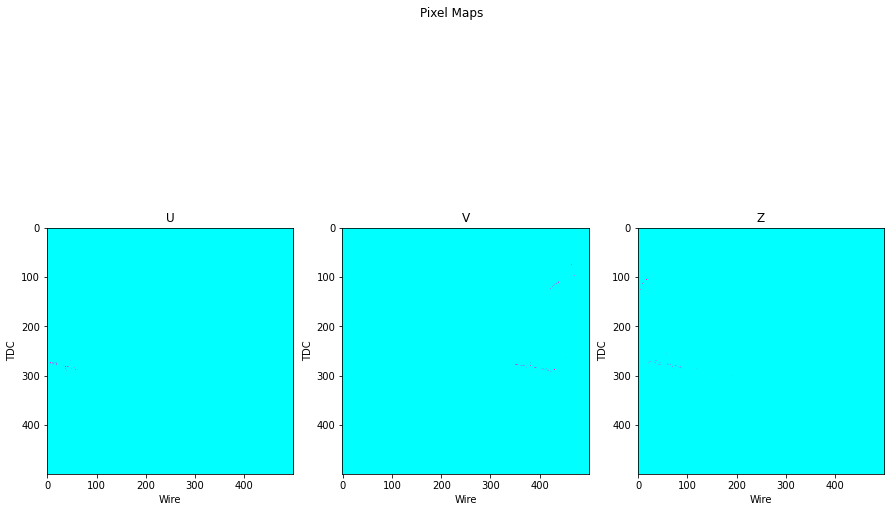

'NC'

In [22]:
draw_single_pm(pm)
flav_keys[labels[ID][1]]

Key :  10
Path :  dataset
location :  dataset/event10.gz


/Users/nitishnayak/for_alissa/cvn_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == "__main__":


CVN score : 0.997898, True Label : NC, Pred Label : NC


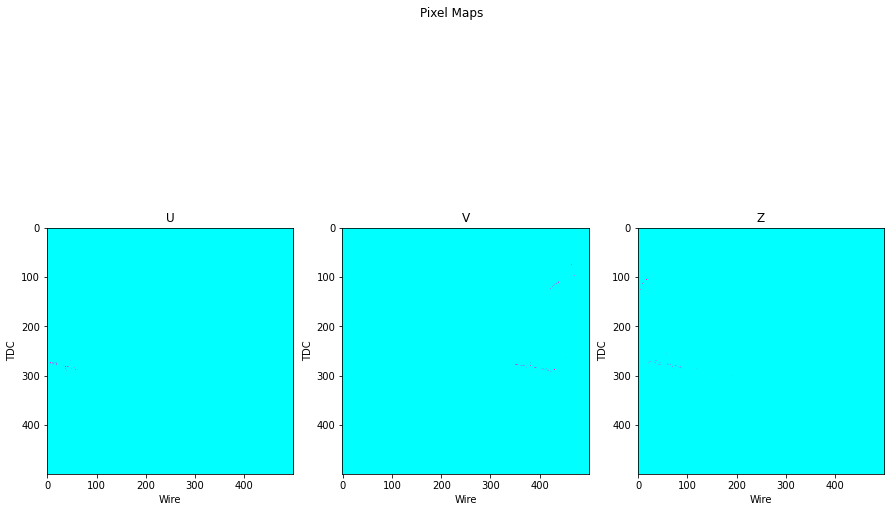

In [36]:
pm = get_pixelmap(ID)
scores = model.predict(convert_pm(pm))
flav_score = np.max(scores[1], axis=1)
flav_pred = np.argmax(scores[1], axis=1)
print('CVN score : %f, True Label : %s, Pred Label : %s'%
      (flav_score[0], flav_keys[labels[ID][1]], flav_keys[flav_pred[0]]))
draw_single_pm(pm)

In [35]:
pm = get_pixelmap(ID)
scores = model.predict(convert_pm(pm))
print(scores[1])
print('Predicted : ', flav_keys[np.argmax(scores[1])])
print('True : ', flav_keys[labels[ID][1]])

Key :  10
Path :  dataset
location :  dataset/event10.gz


/Users/nitishnayak/for_alissa/cvn_venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == "__main__":


[[5.6553796e-05 1.8750564e-03 1.7084886e-04 9.9789751e-01]]
Predicted :  NC
True :  NC


In [62]:
scores[1]*10.

array([[8.8225851e+00, 8.4441621e-04, 1.7875150e-01, 9.9781865e-01]],
      dtype=float32)

CVN score : 0.999569, True Label : NC, Pred Label : NC


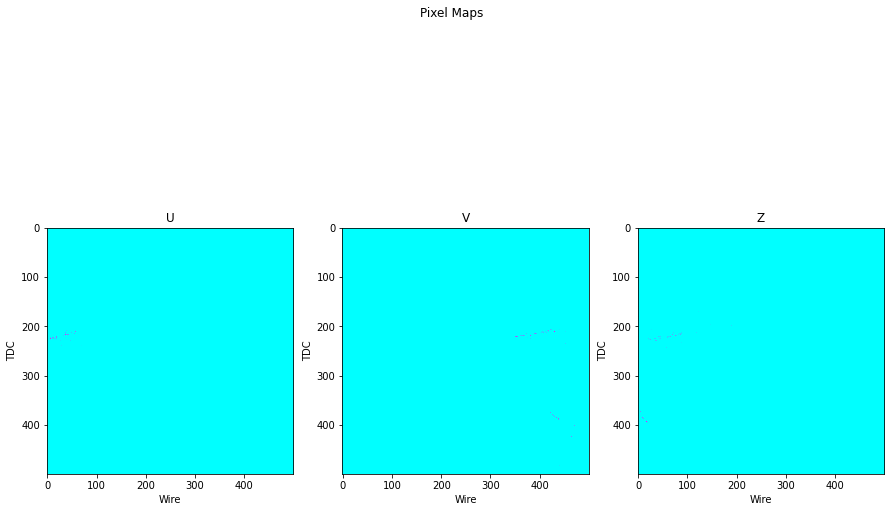

In [38]:
pm2 = np.empty(pm.shape, dtype='float32')
# flips the image
for view in range(3):
    pm2[view] = np.flip(pm[view], axis=1)
#pm[2] = np.empty((500, 500), dtype='')
scores2 = model.predict(convert_pm(pm2))
flav_score2 = np.max(scores2[1], axis=1)
flav_pred2 = np.argmax(scores2[1], axis=1)
print('CVN score : %f, True Label : %s, Pred Label : %s'%
      (flav_score2[0], flav_keys[labels[ID][1]], flav_keys[flav_pred2[0]]))
draw_single_pm(pm2)